In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
import os
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns



/Users/Yanaorfin_1/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from lightgbm import LGBMRegressor

/Users/Yanaorfin_1/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 8.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/Yanaorfin_1/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'
def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE,file_name))

In [5]:
df_sales=read_database('2022-04-01T12_df_sales.csv')
df_sales['date']=pd.to_datetime(df_sales['date'])
df_users=read_database('experiment_users.csv')

df_sales - information about purchases, one row - one order. Attributes:
- sale_id - purchase identifier;
- date - date of purchase;
- count_pizza - number of pizzas in the order;
- count_drink - number of drinks in the order;
- price - price of the order;
- user_id - user identifier;

df_users - list of users of the experiment broken down into groups

In [6]:
df_users.head()

,user_id,pilot
0,0ffc65,0
1,b962b9,0
2,7ea63f,0
3,7f9a61,0
4,459e55,0


In [7]:
df_users['pilot'].value_counts()

pilot
0    11769
1    11564
Name: count, dtype: int64

In [8]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [9]:
# Calculate a metric
begin_daie=datetime(2022,3,23)
end_date=datetime(2022,3,30)
df_metrics=(
    df_sales[(df_sales['date']>=begin_daie)&(df_sales['date']<=end_date)].groupby('user_id')[['price']].sum().reset_index()
)

In [10]:
df_metrics.head()

,user_id,price
0,0000d4,720
1,0000de,660
2,0000e4,840
3,0001e2,2430
4,0001ff,720


In [11]:
df_users_metrics=pd.merge(df_users,df_metrics,how='left',on='user_id').fillna(0)
df_users_metrics.head()


,user_id,pilot,price
0,0ffc65,0,0.0
1,b962b9,0,840.0
2,7ea63f,0,0.0
3,7f9a61,0,0.0
4,459e55,0,0.0


In [12]:
data_control=df_users_metrics[df_users_metrics['pilot']==0]['price']
data_pilot=df_users_metrics[df_users_metrics['pilot']==1]['price']
stats.ttest_ind(data_control,data_pilot)

TtestResult(statistic=-7.800743549967138, pvalue=6.411291718224787e-15, df=23331.0)

**Conclusion:** 
- At the significance level of 0.05, the hypothesis of equality of mean is rejected
- The change is statistically significant

In [13]:
# Calculate a metric for a period
begin_daie=datetime(2022,3,16)
end_date=datetime(2022,3,23)
df_metrics=(
    df_sales[(df_sales['date']>=begin_daie)&(df_sales['date']<=end_date)].groupby('user_id')[['price']].sum().reset_index()
)
df_users_metrics=pd.merge(df_users,df_metrics,how='left',on='user_id').fillna(0)
data_control=df_users_metrics[df_users_metrics['pilot']==0]['price']
data_pilot=df_users_metrics[df_users_metrics['pilot']==1]['price']
stats.ttest_ind(data_control,data_pilot)

TtestResult(statistic=-1.2837567415000515, pvalue=0.19923983306424942, df=23331.0)

**Conclusion:** 
- At the significance level of 0.05, the hypothesis of equality of mean is accepted
- The change is not statistically significant

In [14]:
#Estimate the average time between purchases for customers with 2 or more purchases 

df_2=df_sales.groupby('user_id')[['date']].agg(['count','min','max'])
df_2.columns = [x[1] for x in df_2.columns] # fix column headings 
df_2=df_2[df_2['count']>=2]
df_2['delta']=(df_2['max']-df_2['min']).dt.total_seconds()
sum_delta=df_2['delta'].sum() # total time (in sec) between purchases
count_periods = df_2['count'].sum() - len(df_2) # total number periods between purchases
result=sum_delta/count_periods/3600/24

print("average time between purchases - ", int(round(result)), "days")





average time between purchases -  17 days


In [15]:
# Function to get p-value 

def get_ttest_pvalue(metrics_a_group,metrics_b_group):
   return print("pvalue =",(stats.ttest_ind(metrics_a_group,metrics_b_group).pvalue))

    

In [16]:
def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

In [17]:
# Test the function with example data
metrics_a_group = np.array([964, 1123, 962, 1213, 914, 906, 951, 1033, 987, 1082])
metrics_b_group = np.array([952, 1064, 1091, 1079, 1158, 921, 1161, 1064, 819, 1065])
pvalue = get_ttest_pvalue(metrics_a_group, metrics_b_group)


### MDE. Sample size

In [18]:
web_logs=read_database('2022-04-01T12_df_web_logs.csv')

In [19]:
web_logs.head()


,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


Web-logs - table with logs of site visits.

1. user_id - user ID;
2. page - what page of the site was opened. Page types:
    + m - page with menu;
    + b - page with cart and order confirmation;
    + p - page with order payment;
3. date - date of page opening;
4. load_time - page load time in milliseconds.

**The data is assumed to be independent**

min date- 2022-02-03 23:45:37 max_date- 2022-04-01 11:59:57
(1964507, 4)


<Axes: >

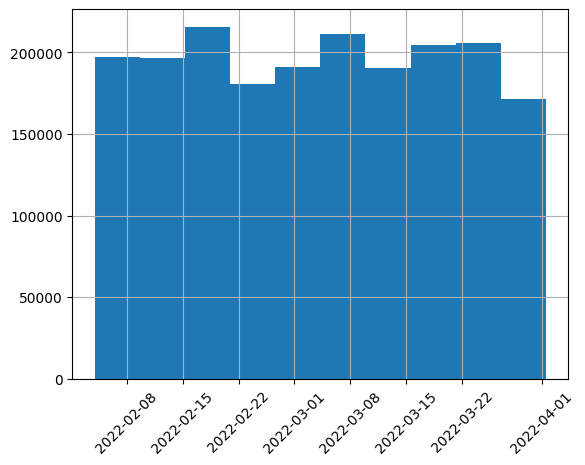

In [20]:
web_logs['date']=pd.to_datetime(web_logs['date'])
print('min date-',web_logs['date'].min(),'max_date-',web_logs['date'].max())
print(web_logs.shape)
web_logs['date'].hist(xrot=45)

In [21]:
#Suppose we want to run the test for one week.
web_logs_hist=web_logs[
    (web_logs['date']>=datetime(2022,3,22)) &
    (web_logs['date']<datetime(2022,3,29))
]
web_logs_hist.shape

(247163, 4)

In [22]:
# for an equel variance 
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, effect_size=1.01, alpha=0.05, beta=0.2): # if we want to calculete relative effect size
    epsilon = (effect_size - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

We want to be able to detect 1% effect in the page load time with a high probability.

In [23]:
# Experiment parameters

alpha=0.05 # significance level
beta=0.2 # power of the test
effect_size=1.01 # 1% effect 

mean=web_logs_hist['load_time'].mean()
std=web_logs_hist['load_time'].std()
print(mean,std)

74.09834562616572 111.56972405581008


In [24]:
sample_size=get_sample_size_abs(mean/100,std,alpha=alpha,beta=beta) 
print("Sample size for each group:", sample_size)


Sample size for each group: 355889


Since sample size for each group is 355889, the experiment requires 700 000 observations, while we have only 247 000. 
What effect can be detected with current amount of oservations? 

In [25]:
def get_minimal_determinable_effect (std,sample_size, alpha=0.05, beta=0.2):
    t_alpha=norm.ppf(1-alpha/2, loc=0,scale=1)
    t_beta=norm.ppf(1-beta, loc=0,scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [26]:
mde=get_minimal_determinable_effect(std,web_logs_hist.shape[0] //2,alpha=alpha,beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

mde = 1.257
mde = 1.697%


with 247 000 observations we can detect 1.697% effect 

How many pages downloads do we need to detect 3% effect? 

In [27]:
alpha = 0.05
beta = 0.2
eff = 1.03
sample_size=get_sample_size_arb(mean,std,effect_size=eff,alpha=alpha,beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 39544


How many customers do we need in each group? 

In [28]:
ratio=web_logs_hist.groupby(['user_id'])['load_time'].count().mean()
print(ratio)

7.015298592188919


In [29]:
n_users=int(sample_size/ratio)+1
print(f'n_users = {n_users}')

n_users = 5637


Therefore, based on historical data, each group requires 6,000 users to be allocated to each group that will generate enough traffic that we are able to capture the 3% effect at a significance level of 0.05 and a power of 0

In [30]:


sales=read_database('2022-04-01T12_df_sales.csv')
sales['date']=pd.to_datetime(sales['date'])
sales_hist=sales[
    (sales['date']>=datetime(2022,2,21)) &
    (sales['date']<datetime(2022,2,28))
]
sales_hist.head() 


,sale_id,date,count_pizza,count_drink,price,user_id
63207,1063208,2022-02-21 10:02:02,4,1,3030,fcaa0f
63208,1063209,2022-02-21 10:04:43,3,1,2250,8d8445
63209,1063210,2022-02-21 10:05:40,1,0,780,e21af3
63210,1063211,2022-02-21 10:09:01,4,0,2880,e23104
63211,1063212,2022-02-21 10:11:20,2,1,1620,748932


In [31]:
begin_date = datetime(2022, 2, 21)
end_date = datetime(2022, 2, 28)
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .reset_index())
df_metrics.shape

(24840, 2)

In [32]:
sales_hist.shape

(25347, 6)

In [33]:
mean=sales_hist['price'].mean()
std=sales_hist['price'].std()
print(mean,std)

1209.9905314238372 783.1782330895525


In [34]:
mean=df_metrics['price'].mean()
std=df_metrics['price'].std()
print(mean,std)

1234.6871980676328 811.1803387604912


In [35]:
sample_size=get_sample_size_abs(20, std, alpha=alpha, beta=beta)
alpha = 0.05
beta = 0.1
eff = 20 # 20 usd effect 
print(f'sample_size = {round(sample_size,-1)}')

sample_size = 25820


In [36]:
mde=get_minimal_determinable_effect(std,df_metrics.shape[0]//2,alpha=alpha,beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

mde = 33.367
mde = 2.702%


In [37]:
def estimate_sample_size(metrics, effect, alpha, beta):
    std = np.std(metrics['metric'].values)
    mean = np.mean(metrics['metric'].values)
    epsilon = effect / 100 * mean
    # ratio of the number of unique users to the number of observations
    coef = metrics['user_id'].nunique() / len(metrics)
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2) * coef
        )
    )
    return sample_size

### Experiment design test

In [38]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')

In [39]:
sales = read_database('2022-04-01T12_df_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


2022-02-04 10:00:24
2022-04-01 11:59:51
(203847, 6)


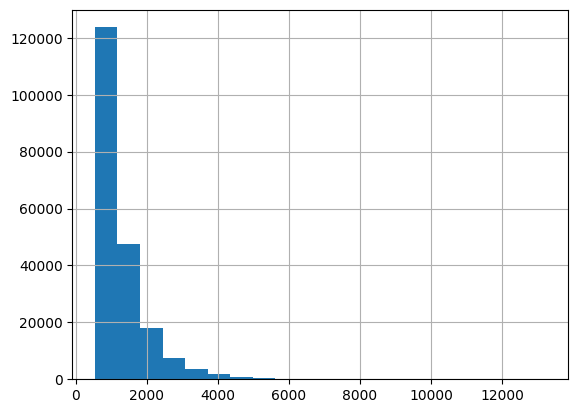

In [40]:
print(sales['date'].min())
print(sales['date'].max())
print(sales.shape)
sales['price'].hist(bins=20);

Let's assume that we want to run the test for 4 weeks.

For this purpose, we will choose an interval of one week on the historical interval and perform all calculations for this time interval. Note that today is April 1, so we have taken the week immediately before the start of the experiment.

In [41]:
sales_hist=sales[
    (sales['date']>=datetime(2022,3,1)) &
    (sales['date']<datetime(2022,3,29))
]
sales_hist.shape

(101951, 6)

In [42]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

To check the correctness of the experiment design, we must simulate this experiment on historical data many times. First, let us check whether the probability of the 1st type of error is controlled. For this purpose, the objects in our sample will be **checks**. That is, we divide all people into 2 groups, collect all checks independently, and run a t-test.

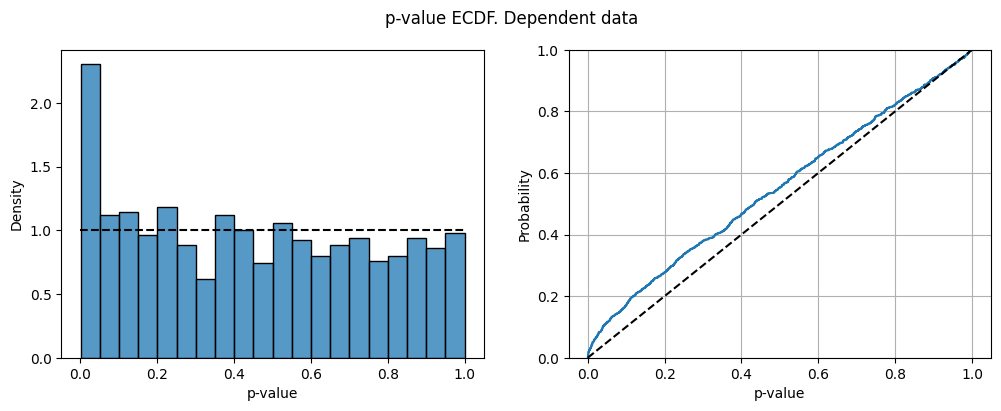

In [43]:
p_values=[]
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=sales_hist[sales_hist['user_id'].isin(group_a)]['price']
    sales_b=sales_hist[sales_hist['user_id'].isin(group_b)]['price']
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

In [44]:
print((np.array(p_values) < 0.05).mean(),'real probability of false positive result (I type error) with significance level 0.05')

0.115 real probability of false positive result (I type error) with significance level 0.05


This behavior is due to the fact that the sample does not satisfy the regularity conditions of the t-test, in particular, the observations are **not independent** because one person may make multiple purchases during the experiment.

To make the data independent, let's calculate the metric **average check per user**. The data will be statistically independent, because we will get one value from each user, and users are independent among themselves.

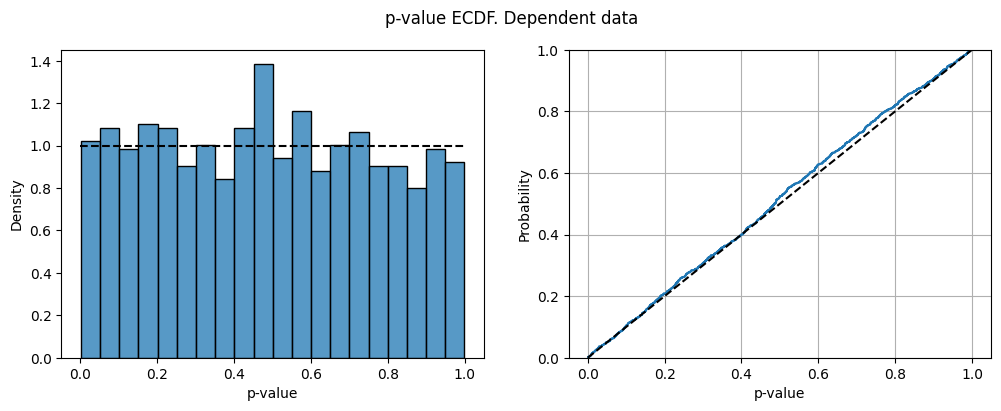

In [45]:
p_values=[]
grouped_sales=sales_hist.groupby('user_id')['price'].mean().reset_index()
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b=grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

Test power 

In [46]:
mean =grouped_sales['price'].mean()
std= grouped_sales['price'].std()
sample_size=grouped_sales.shape[0] // 2
alpha0= 0.05
beta0= 0.2
mde = get_minimal_determinable_effect(std, sample_size, alpha=alpha0, beta=beta0)
print(f'mde = {np.round(mde, 3)}')

mde = 15.866


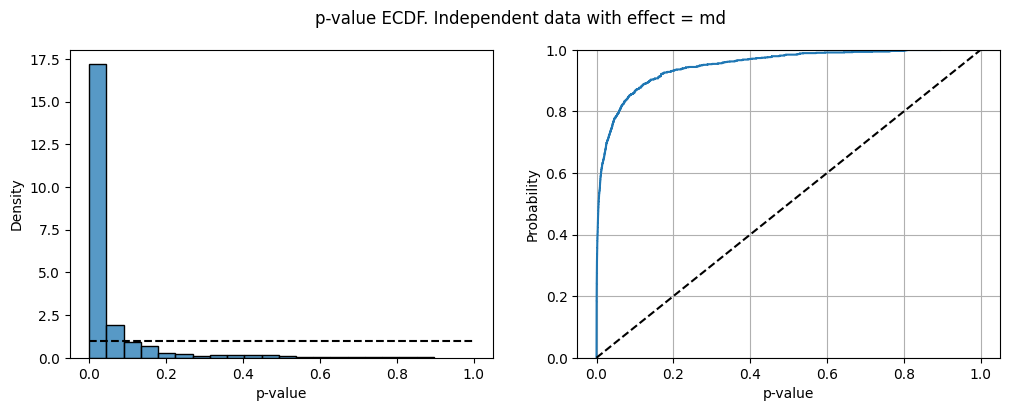

In [47]:
#Test power
p_values=[]
grouped_sales=sales_hist.groupby('user_id')['price'].mean().reset_index()
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b=grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b +=np.random.normal(mde,std // 10,sales_b.shape)   # adding a synthetic effect to historical data + a bit of variance
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = md')

The power of the test on 80% probability to detect a MDE.

In [48]:
def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

def estimate_errors(group_generator, effect_add_type, effect, alpha):
    pvalues_aa = []
    pvalues_ab = []
    for a_metric_values, b_metric_values in group_generator:
        pvalues_aa.append(get_ttest_pvalue(a_metric_values, b_metric_values))
        b_metric_values_with_effect = b_metric_values.copy()
        if effect_add_type == 'all_percent':
            b_metric_values_with_effect *= 1 + effect / 100
        elif effect_add_type == 'all_const':
            b_metric_values_with_effect += b_metric_values_with_effect.mean() * effect / 100
        pvalues_ab.append(get_ttest_pvalue(a_metric_values, b_metric_values_with_effect))
    first_type_error = np.mean(np.array(pvalues_aa) < alpha)
    second_type_error = np.mean(np.array(pvalues_ab) >= alpha)
    return pvalues_aa, pvalues_ab, first_type_error, second_type_error

All users who made purchases before 28 March are included in the A/B test.

 
The target metric is the average revenue per customer during the experiment. The target metric is calculated for the week of 21 to 28 March. The significance level is 0.05. The criterion is Student's t-test. The group size is 1,000. The expected effect is that average revenue will increase by 10%.

We need to estimate the probabilities of Type II errors for three options for adding the effect:

1. Adding a constant to all values;

2. Multiplying all values by a constant;

3. Adding a constant to 2.5% of values.
In response, the numbers of methods for adding the effect are entered in order of increasing probability of Type II error.

In [166]:
from tqdm.notebook import tqdm
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'


df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

begin_date = datetime(2022, 3, 21)
end_date = datetime(2022, 3, 28)
df_users = df_sales[df_sales['date'] < end_date][['user_id']].drop_duplicates()
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .reset_index()  
)
df = pd.merge(df_users, df_metrics, on='user_id', how='left').fillna(0)

alpha = 0.05
sample_size = 1000
effect = 0.1

pvalues = {'one': [], 'two': [], 'three': []}
values = df['price'].values
mean_ = values.mean()

for _ in tqdm(range(30000)):
    # select random groups
    a, b = np.random.choice(values, (2, sample_size,), False)
    # add effect in three ways
    b_one = b + mean_ * effect
    b_two = b * (1 + effect)
    indexes = np.random.choice(np.arange(sample_size), int(sample_size * 0.025), False)
    add_value = effect * mean_ * sample_size / len(indexes)
    mask = np.zeros(sample_size)
    mask[indexes] += 1
    b_three = b + mask * add_value
    # calculate and save p-value
    for b_, key in ((b_one, 'one',), (b_two, 'two',), (b_three, 'three',),):
        pvalues[key].append(stats.ttest_ind(a, b_).pvalue)

# calculate point estimates of type II error probabilities
for key, v in pvalues.items():
    errors = (np.array(v) > alpha).astype(int)
    part_errors = np.mean(errors)
    print(f'{key}: part errors = {part_errors:0.4f}')

# check if differences are statistically significant
print(stats.ttest_ind(pvalues['one'], pvalues['three']).pvalue)
print(stats.ttest_ind(pvalues['two'], pvalues['three']).pvalue)

  0%|          | 0/30000 [00:00<?, ?it/s]

one: part errors = 0.8128
two: part errors = 0.8282
three: part errors = 0.8237
0.007121345015999292
0.024885200768949095


## Bootstrap & confidence intervals

### 3 ways to build confidence intervals

In [49]:
def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):

    """ Builds a normal confidence interval.

    boot_metrics - metric values obtained with bootstrap
    pe_metric - point estimate of the metric
    alpha - significance level.
    
    return: (left, right) - boundaries of the confidence interval.
    """

    c = stats.norm.ppf(1 - alpha / 2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right


def get_ci_bootstrap_percentile(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Constructs a confidence interval at percentiles.

    boot_metrics - metric values obtained with bootstrap
    pe_metric - point estimate of the metric
    alpha - significance level
    
    return: (left, right) - boundaries of the confidence interval.
    """
    left, right = np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
    return left, right


def get_ci_bootstrap_pivotal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Constructs the central confidence interval.

    boot_metrics - metric values obtained with bootstrap
 pe_metric - point estimate of the metric
 alpha - significance level
    
    return: (left, right) - boundaries of the confidence interval.
    """
    right, left = 2 * pe_metric - np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
    return left, right

In [50]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

web_logs=read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date']=pd.to_datetime(web_logs['date'])
web_logs.head(5)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [51]:
np.random.seed(23)
web_logs_hist=web_logs
users=web_logs_hist['user_id'].unique()

np.random.shuffle(users)
group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
load_time_a=web_logs_hist[web_logs_hist['user_id'].isin(group_a)]['load_time'].values
load_time_b=web_logs_hist[web_logs_hist['user_id'].isin(group_b)]['load_time'].values

Our goal will be to construct a $95\%$ confidence interval for the $99.9%$ percentile difference.
$$H_0: P_{B; 99.9} = P_{A; 99.9}$$
$$H_1: P_{B; 99.9} \neq P_{A; 99.9}$$
First, let's implement a function with which we can get a point estimate

In [52]:
def get_point_estimate(a_group,b_group,quantile=0.999):
    return np.quantile(b_group,quantile) - np.quantile(a_group,quantile)

Let's run the usual bootstrap procedure, but taking into account that we have two samples. To do this, we will independently sample subsamples of the same size from the groups and calculate the bootstrap estimate. Let's repeat this procedure 1000 times.

In [53]:
point_estimate=get_point_estimate(load_time_a, load_time_b)
print(point_estimate)

-108.90149999987307


In [54]:
bs_point_estimates = []
for _ in range(1000):
    bs_a=np.random.choice(load_time_a,size=len(load_time_a),replace=True)
    bs_b=np.random.choice(load_time_b,size=len(load_time_b),replace=True)
    bs_point_estimate=get_point_estimate(bs_a, bs_b)
    bs_point_estimates.append(bs_point_estimate)

In [55]:
normal_ci=get_ci_bootstrap_normal(bs_point_estimates,point_estimate)
percentile_ci=get_ci_bootstrap_percentile(bs_point_estimates,point_estimate)
pivoval_ci=get_ci_bootstrap_pivotal(bs_point_estimates,point_estimate)

print(normal_ci,percentile_ci,pivoval_ci )

(-280.7299931076849, 62.926993107938785) (-282.4124074999948, 47.75602000067741) (-265.5590200004235, 64.60940750024866)


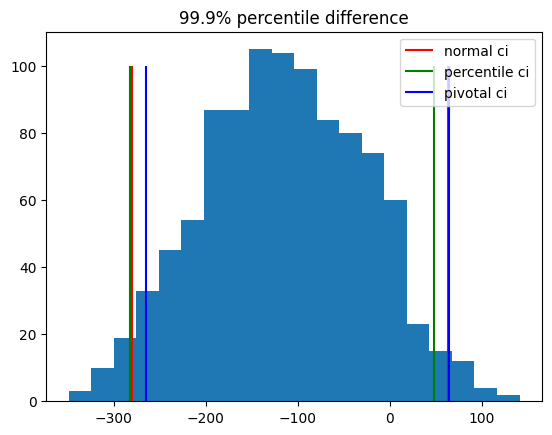

In [56]:
plt.title('99.9% percentile difference')
plt.hist(bs_point_estimates,bins=20)
plt.vlines(normal_ci,0,100,label='normal ci', color='red')
plt.vlines(percentile_ci,0,100,label='percentile ci', color='green')
plt.vlines(pivoval_ci,0,100,label='pivotal ci', color='blue')
plt.legend()
plt.show()


**Conclusion**: zero is inside the confidence interval, which means we cannot reject the null hypothesis that the 99.9 percentile is statistically significantly different.

### Experiment 
The experiment was conducted from 2022-04-05 to 2022-04-12. The measurements of request processing time are considered independent.

In [57]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-13/' 

web_logs=read_database('2022-04-13T12_df_web_logs.csv')
web_logs['date']=pd.to_datetime(web_logs['date'])
web_logs.head(5)


,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [58]:
df_users=read_database('experiment_users.csv')
df_users.head()

,user_id,pilot
0,c36b2e,0
1,20336e,0
2,034652,0
3,e98e3b,0
4,3f1105,0


In [59]:
begin_date=datetime(2022,4,5)
end_date=datetime(2022,4,12)
df_metrics=(
    web_logs[
        (web_logs['date']>=begin_date) &
        (web_logs['date']< end_date)
    ][['user_id','load_time']]
)
df= pd.merge(df_users,df_metrics, how='left',on='user_id')
df.describe()

,pilot,load_time
count,38936.000000,38936.000000
mean,0.505085,75.762854
std,0.499981,116.208595
min,0.000000,0.000000
25%,0.000000,65.100000
50%,1.000000,71.900000
75%,1.000000,78.400000
max,1.000000,4176.600000


In [60]:
B=1000 # number of bootstrap iterations
alpha=0.05

values_a=df[df['pilot']==0]['load_time'].values
values_b=df[df['pilot']==1]['load_time'].values
quantiles=np.array([0.7, 0.74, 0.78, 0.82, 0.86, 0.9, 0.95, 0.99, 0.999, 0.9999])
for q in quantiles:
    pe=np.quantile(values_b,q)-np.quantile(values_a,q)
    bootstrap_values_a=np.random.choice(values_a,(B,len(values_a)),replace=True)
    bootstrap_metrics_a=np.quantile(bootstrap_values_a,q,axis=1)
    bootstrap_values_b=np.random.choice(values_b,(B, len(values_b)), replace=True)
    bootstrap_metrics_b=np.quantile(bootstrap_values_b,q,axis=1)
    bootstrap_stats=bootstrap_metrics_b-bootstrap_metrics_a
    left,right=get_ci_bootstrap_normal(bootstrap_stats,pe,alpha=alpha)
    print(f'q = {q}, ci = [{left:0.3f}, {right:0.3f}], is effect = {not(left < 0 < right)} ')



q = 0.7, ci = [0.723, 1.277], is effect = True 
q = 0.74, ci = [0.301, 0.899], is effect = True 
q = 0.78, ci = [-0.295, 0.295], is effect = False 
q = 0.82, ci = [-1.016, -0.384], is effect = True 
q = 0.86, ci = [-1.553, -0.847], is effect = True 
q = 0.9, ci = [-2.475, -1.725], is effect = True 
q = 0.95, ci = [-3.892, -3.018], is effect = True 
q = 0.99, ci = [-7.314, -5.286], is effect = True 
q = 0.999, ci = [-1932.239, 1153.969], is effect = False 
q = 0.9999, ci = [-401.864, 465.289], is effect = False 


In [61]:
def run_bootstrap(bootstrap_metrics, pe_metric, alpha, bootstrap_ci_type):
    if bootstrap_ci_type == 'normal':
        c = stats.norm.ppf(1 - alpha / 2) 
        se = np.std(bootstrap_metrics)
        left, right = pe_metric - c * se, pe_metric + c * se
    elif bootstrap_ci_type == 'percentile':
        left, right = np.quantile(bootstrap_metrics, [alpha / 2, 1 - alpha / 2])
    elif bootstrap_ci_type == 'pivotal':
        q = np.quantile(bootstrap_metrics, [alpha / 2, 1 - alpha / 2])
        right, left = 2 * pe_metric - q
    else:
        raise ValueError('False bootstrap_ci_type')
    pvalue = float(left < 0 < right)
    return (left, right,), pvalue

## Variance reduction

In [62]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [63]:
web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date']=pd.to_datetime(web_logs['date'])
web_logs.head(5)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [64]:
web_logs.describe()

,date,load_time
count,1964507,1.964507e+06
mean,2022-03-04 00:19:28.621828352,7.396452e+01
min,2022-02-03 23:45:37,0.000000e+00
25%,2022-02-18 10:48:42.500000,6.180000e+01
50%,2022-03-04 10:07:06,7.000000e+01
75%,2022-03-18 11:35:15.500000,7.810000e+01
max,2022-04-01 11:59:57,4.197500e+03
std,NaN,1.107026e+02


In [65]:
web_logs_hist = web_logs[
    (web_logs['date'] >= datetime(2022, 3, 22))
    & (web_logs['date'] < datetime(2022, 3, 29))
]
web_logs_hist.shape

(247163, 4)

In [66]:
alpha = 0.05
beta = 0.2

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

eff = mean * 0.01
print(f"variance is {std ** 2}")

variance is 12447.803325889607


In [67]:
sample_size = get_sample_size_abs(eff, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 355889


<Axes: >

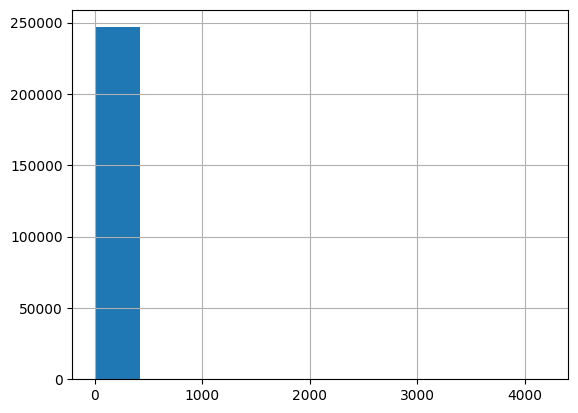

In [68]:
web_logs_hist['load_time'].hist()

<Axes: >

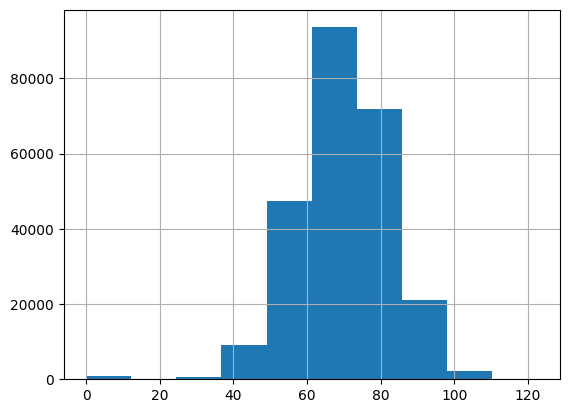

In [69]:
# without outliers
web_logs_filtered=web_logs_hist[web_logs_hist['load_time']<1000]
web_logs_filtered['load_time'].hist()


In [70]:
std = web_logs_filtered['load_time'].std()
print(f"var is {std ** 2}")

var is 162.0907235349538


In [71]:
sample_size=get_sample_size_abs(eff,std,alpha=alpha,beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 4635


The variance dropped by a factor of more than 76, causing the required sample size to drop by a factor of 76.

In [162]:


URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'


df_web_logs = read_database('2022-04-01T12_df_web_logs.csv')
df_web_logs['date'] = pd.to_datetime(df_web_logs['date'])

begin_date = datetime(2022, 3, 1)
end_date = datetime(2022, 3, 8)
df_metrics = (
    df_web_logs
    [(df_web_logs['date'] >= begin_date) & (df_web_logs['date'] < end_date)]
    [['user_id', 'load_time']]
)
users = df_metrics['user_id'].unique()

sample_size = 1000
effect = 0.01
alpha = 0.05
quantiles = (0.0001, 0.001, 0.01, 0.05, 0.1,)
quantile2errors = {q: [] for q in quantiles}

for _ in range(10000):
    a_users, b_users = np.random.choice(users, (2, sample_size,), False)
    a_values = df_metrics.loc[df_metrics['user_id'].isin(a_users), 'load_time'].values
    b_values = (
        df_metrics.loc[df_metrics['user_id'].isin(b_users), 'load_time'].values
        * (1 + effect)
    )
    for q in quantiles:
        a_values_filtered = a_values[
            (a_values > np.quantile(a_values, q))
            & (a_values < np.quantile(a_values, 1-q))
        ]
        b_values_filtered = b_values[
            (b_values > np.quantile(b_values, q))
            & (b_values < np.quantile(b_values, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)

def process_results(quantile2errors):
    """process the data and display the result.."""
    # list of elements: option number, quantile, error rate, list of errors).
    data = [
        (idx+1, quantile, np.mean(errors), errors,)
        for idx, (quantile, errors) in enumerate(quantile2errors.items())
    ]
    # sort by error rate
    data.sort(key=lambda x: x[2])

    # check if power estimates differ significantly from each other
    print(f'idx={data[0][0]} quantile={data[0][1]}, power={1-data[0][2]:0.3f}')
    for i in range(1, len(data)):
        pvalue = stats.ttest_ind(data[i][3], data[i-1][3]).pvalue
        if pvalue < 0.05:
            msg = f'pvalue={pvalue:0.4f}, the power estimate differs significantly from the previous one.'
        else:
            msg = f'pvalue={pvalue:0.4f}, the power estimate does not differ significantly from the previous one.'
        print(f'idx={data[i][0]} quantile={data[i][1]}, power={1-data[i][2]:0.3f}, {msg}')
    print('answer:', ''.join([str(x[0]) for x in data]))

process_results(quantile2errors)


idx=5 quantile=0.1, power=0.969
idx=4 quantile=0.05, power=0.958, pvalue=0.0001, the power estimate differs significantly from the previous one.
idx=3 quantile=0.01, power=0.936, pvalue=0.0000, the power estimate differs significantly from the previous one.
idx=2 quantile=0.001, power=0.344, pvalue=0.0000, the power estimate differs significantly from the previous one.
idx=1 quantile=0.0001, power=0.092, pvalue=0.0000, the power estimate differs significantly from the previous one.
answer: 54321


In [163]:
sample_size = 1000
effect = 0.01
alpha = 0.05
quantiles = (0.0001, 0.001, 0.01, 0.05, 0.1,)
quantile2errors = {q: [] for q in quantiles}

for _ in range(10000):
    a_users, b_users = np.random.choice(users, (2, sample_size,), False)
    a_values = df_metrics.loc[df_metrics['user_id'].isin(a_users), 'load_time'].values
    b_values = df_metrics.loc[df_metrics['user_id'].isin(b_users), 'load_time'].values
    mean_ = b_values.mean()
    indexes = np.random.choice(np.arange(len(b_values)), int(len(b_values) / 100), False)
    b_values[indexes] += mean_ * effect * len(b_values) / len(indexes)

    for q in quantiles:
        a_values_filtered = a_values[
            (a_values > np.quantile(a_values, q))
            & (a_values < np.quantile(a_values, 1-q))
        ]
        b_values_filtered = b_values[
            (b_values > np.quantile(b_values, q))
            & (b_values < np.quantile(b_values, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)

process_results(quantile2errors)


idx=3 quantile=0.01, power=0.460
idx=2 quantile=0.001, power=0.353, pvalue=0.0000, the power estimate differs significantly from the previous one.
idx=5 quantile=0.1, power=0.324, pvalue=0.0000, the power estimate differs significantly from the previous one.
idx=4 quantile=0.05, power=0.298, pvalue=0.0001, the power estimate differs significantly from the previous one.
idx=1 quantile=0.0001, power=0.093, pvalue=0.0000, the power estimate differs significantly from the previous one.
answer: 32541


### Experiment  (Synthetic data)

Power of tests depending on the proportion of data to be deleted.

In [72]:

df_web_logs = read_database('2022-04-01T12_df_web_logs.csv')
df_web_logs['date'] = pd.to_datetime(df_web_logs['date'])

begin_date = datetime(2022, 3, 1)
end_date = datetime(2022, 3, 8)
df_metrics = (
    df_web_logs
    [(df_web_logs['date'] >= begin_date) & (df_web_logs['date'] < end_date)]
    [['user_id', 'load_time']]
)
users = df_metrics['user_id'].unique()

sample_size = 1000 # 1000 users
effect = 0.01 # 1% effect
alpha = 0.05
quantiles = (0.0001, 0.001, 0.01, 0.05, 0.1,)
quantile2errors = {q: [] for q in quantiles}

for _ in range(10000):
    a_users, b_users = np.random.choice(users, (2, sample_size,), False)
    a_values = df_metrics.loc[df_metrics['user_id'].isin(a_users), 'load_time'].values
    b_values = (
        df_metrics.loc[df_metrics['user_id'].isin(b_users), 'load_time'].values
        * (1 + effect) # adding a synthetic effect to historical data


    ) #Remove 2% of the outliers means removing 1% each of the minimum and maximum sample values. 
#That is, leave the values that lie between np.quantile(values, 0.01) and np.quantile(values, 0.99).
    for q in quantiles:
        a_values_filtered = a_values[
            (a_values > np.quantile(a_values, q))
            & (a_values < np.quantile(a_values, 1-q))
        ]
        b_values_filtered = b_values[
            (b_values > np.quantile(b_values, q))
            & (b_values < np.quantile(b_values, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)

def process_results(quantile2errors):
    """Process the data and output the result"""
    # list of elements: variant number, quantile, error rate, error list)
    data = [
        (idx+1, quantile, np.mean(errors), errors,)
        for idx, (quantile, errors) in enumerate(quantile2errors.items())
    ]
    # sort by error rate
    data.sort(key=lambda x: x[2])

     # check that the power estimates are meaningfully different from each other
    print(f'idx={data[0][0]} quantile={data[0][1]}, power={1-data[0][2]:0.3f}')
    for i in range(1, len(data)):
        pvalue = stats.ttest_ind(data[i][3], data[i-1][3]).pvalue
        if pvalue < 0.05:
            msg = f'pvalue={pvalue:0.4f}, the estimate of statistic power is significantly different from the previous'
        else:
            msg = f'pvalue={pvalue:0.4f}, the estimate of statistic power is not significantly different from the previous'
        print(f'idx={data[i][0]} quantile={data[i][1]}, power={1-data[i][2]:0.3f}, {msg}')
    print('answer:', ''.join([str(x[0]) for x in data]))

process_results(quantile2errors)

idx=5 quantile=0.1, power=0.970
idx=4 quantile=0.05, power=0.960, pvalue=0.0001, the estimate of statistic power is significantly different from the previous
idx=3 quantile=0.01, power=0.937, pvalue=0.0000, the estimate of statistic power is significantly different from the previous
idx=2 quantile=0.001, power=0.336, pvalue=0.0000, the estimate of statistic power is significantly different from the previous
idx=1 quantile=0.0001, power=0.089, pvalue=0.0000, the estimate of statistic power is significantly different from the previous
answer: 54321


In [73]:
def process_outliers(metrics, bounds, outlier_process_type):
    lower_bound, upper_bound = bounds
    metrics = metrics.copy()
    if outlier_process_type == 'drop':
        metrics = metrics[(metrics['metric'] >= lower_bound) & (metrics['metric'] <= upper_bound)]
    elif outlier_process_type == 'clip':
        metrics.loc[metrics['metric'] < lower_bound, 'metric'] = lower_bound
        metrics.loc[metrics['metric'] > upper_bound, 'metric'] = upper_bound
    else:
        raise ValueError('Invalid value of outlier_process_type')
    return metrics

In [ ]:
# The effect in synthetic A/B tests is added by adding a constant to 1% of the data.
sample_size = 1000
effect = 0.01
alpha = 0.05
quantiles = (0.0001, 0.001, 0.01, 0.05, 0.1,)
quantile2errors = {q: [] for q in quantiles}

for _ in range(10000):
    a_users, b_users = np.random.choice(users, (2, sample_size,), False)
    a_values = df_metrics.loc[df_metrics['user_id'].isin(a_users), 'load_time'].values
    b_values = df_metrics.loc[df_metrics['user_id'].isin(b_users), 'load_time'].values
    mean_ = b_values.mean()
    indexes = np.random.choice(np.arange(len(b_values)), int(len(b_values) / 100), False)
    b_values[indexes] += mean_ * effect * len(b_values) / len(indexes)

    for q in quantiles:
        a_values_filtered = a_values[
            (a_values > np.quantile(a_values, q))
            & (a_values < np.quantile(a_values, 1-q))
        ]
        b_values_filtered = b_values[
            (b_values > np.quantile(b_values, q))
            & (b_values < np.quantile(b_values, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)

process_results(quantile2errors)

idx=3 quantile=0.01, power=0.459
idx=2 quantile=0.001, power=0.345, pvalue=0.0000, the power estimate differs significantly from the previous one.
idx=5 quantile=0.1, power=0.325, pvalue=0.0024, the power estimate differs significantly from the previous one.
idx=4 quantile=0.05, power=0.304, pvalue=0.0014, the power estimate differs significantly from the previous one.
idx=1 quantile=0.0001, power=0.093, pvalue=0.0000, the power estimate differs significantly from the previous one.
answer: 32541


In [165]:
def process_outliers(metrics, bounds, outlier_process_type):
    lower_bound, upper_bound = bounds
    metrics = metrics.copy()
    if outlier_process_type == 'drop':
        metrics = metrics[(metrics['metric'] >= lower_bound) & (metrics['metric'] <= upper_bound)]
    elif outlier_process_type == 'clip':
        metrics.loc[metrics['metric'] < lower_bound, 'metric'] = lower_bound
        metrics.loc[metrics['metric'] > upper_bound, 'metric'] = upper_bound
    else:
        raise ValueError('Invalid outlier_process_type')
    return metrics

### KPI choise 

In [74]:
df = pd.DataFrame({
    'revenue': [1500, 1800, 2100],
    'cost_price': [1300, 1200, 1600],
    'support': [1, 0, 0],
})
support_cost = 110

# metric = pd.Series([90, 600, 500])
def get_metric(df, support_cost):
    profit = df['revenue'] - df['cost_price'] - (df['support'] * support_cost)
    return profit

metric = get_metric(df, support_cost)
print(metric)

0     90
1    600
2    500
dtype: int64


In [75]:
sample_size = 1000
df_control = pd.DataFrame({
    'revenue': [int(np.sin(x / 12) * 600 + 1200) for x in range(sample_size)],
    'cost_price': [int(np.sin(x / 12) * 400 + 700) for x in range(sample_size)],
    'support': (np.arange(sample_size) < sample_size - 400).astype(int),
})
df_pilot = pd.DataFrame({
    'revenue': [int(np.sin(x / 11 + 1) * 650 + 1250) for x in range(sample_size)],
    'cost_price': [int(np.sin(x / 11 + 1) * 400 + 700) for x in range(sample_size)],
    'support': (np.arange(sample_size) < sample_size - 300).astype(int),
})
def get_metric(df, support_cost):
    return df['revenue'] - df['cost_price'] - support_cost * df['support']

for support_cost in range(316, 319):
    control_metric = get_metric(df_control, support_cost)
    pilot_metric = get_metric(df_pilot, support_cost)
    delta = pilot_metric.mean() - control_metric.mean()
    pvalue = ttest_ind(control_metric, pilot_metric).pvalue
    print(f'support_cost={support_cost} delta={delta:0.1f}, pvalue={pvalue:0.4f}')

support_cost=316 delta=19.5, pvalue=0.0484
support_cost=317 delta=19.4, pvalue=0.0499
support_cost=318 delta=19.3, pvalue=0.0515


### Stratification

In [76]:
from tqdm.notebook import tqdm

In [77]:
def calculate_mean(df):
    """Calculates the normal average of the ‘metric’ column."""
    return df['metric'].mean()


def calculate_stratified_mean(df, weights):
    """Calculates the stratified average.

    df - dataframe with target metric and data for stratification
    weights - dictionary - {stratum name: stratum weight}

    return: float, mean_strat
    """
    strat_mean = df.groupby('strat')['metric'].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # ! if there were no strats in the df data, then some of the weights will be erased and the sum of weights will be less than 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['metric']).sum()
    return mean_strat


def check_test(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних для обычного среднего.
    
    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    return pvalue

def calculate_strat_var(df, weights):
    """Calculates the stratified variance."""
    strat_vars = df.groupby('strat')['metric'].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # ! if there were no strats in the df data, then some of the weights will be erased and the sum of weights will be less than 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights['metric']).sum()
    return var_strat

def check_stratified_test(df_control, df_pilot, weights):
    """Checks the hypothesis of equality of means for the stratified mean.

    return - pvalue.
    """
    mean_strat_control = calculate_stratified_mean(df_control, weights)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights)
    var_strat_control = calculate_strat_var(df_control, weights)
    var_strat_pilot = calculate_strat_var(df_pilot, weights)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue


In [78]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01/2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_user_strats = read_database('user_strats.csv')

In [79]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [80]:
df_user_strats.head()

,user_id,strat
0,000096,1
1,0000d4,1
2,0000de,1
3,0000e4,1
4,0000e7,1


In [81]:
df_user_strats['strat'].value_counts()

strat
1    58285
3    53518
2    11644
Name: count, dtype: int64

In [82]:
begin_date = datetime(2022, 3, 23)
end_date = datetime(2022, 3, 30)
df_metrics=(
    df_sales[(df_sales['date']>=begin_date) & (df_sales['date']<=end_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price':'metric'})
    .reset_index()
)
df_metrics=pd.merge(df_metrics, df_user_strats, how='left', on='user_id')
df_metrics.head()

,user_id,metric,strat
0,0000d4,720,1
1,0000de,660,1
2,0000e4,840,1
3,0001e2,2430,1
4,0001ff,720,1


In [83]:
df_metrics.groupby('strat')['metric'].mean()

strat
1    1221.697525
2    1251.554174
3    1227.406882
Name: metric, dtype: float64

  0%|          | 0/1000 [00:00<?, ?it/s]

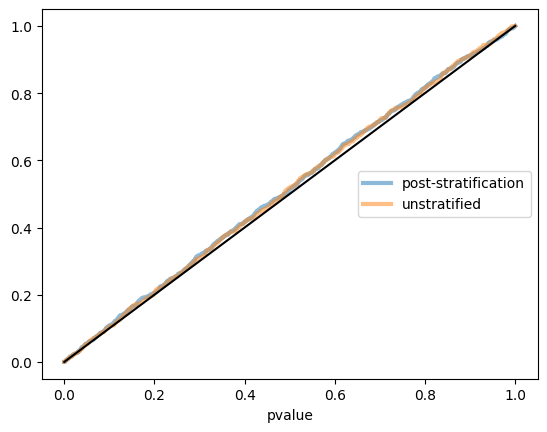

In [84]:
# Poststratification 
sample_size = 1000
weights = df_user_strats['strat'].value_counts(normalize=True).to_dict()
effect = 0

pvalues_random =[]
pvalues_poststratified =[]

for _ in tqdm (range(1000)):
    control_users, pilot_users = np.random.choice(df_metrics['user_id'].values, (2, sample_size,), False)
    df_control = df_metrics[df_metrics['user_id'].isin(control_users)].copy()
    df_pilot = df_metrics[df_metrics['user_id'].isin(pilot_users)].copy()
    df_pilot['metric'] += effect
    pvalues_random.append(check_test(df_control, df_pilot))
    pvalues_poststratified.append(check_stratified_test(df_control, df_pilot, weights))


list_pvalues = [pvalues_random, pvalues_poststratified]
list_titles = ['unstratified', 'post-stratification']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()


In [85]:
# split the features into strats 
def get_strats(df_features):
    return [
        str(int(26 <= x <= 34)) + str(int(28 <= x <= 32)) + str(int(y > 1)) + str(int(a == b))
        for x, y, a, b in df_features[['x2', 'x10', 'x5', 'x9']].values
    ]


### split the features into strats with LightGBM
from LightGBM import LGBMRegressor

df_train = df.iloc[:len(df) // 2].copy()
df_test = df.iloc[len(df) // 2:].copy()

model = LGBMRegressor(num_leaves=3)
feature_names = [f'x{i}' for i in range(1, 11)]
model.fit(df_train[feature_names].values, df_train['y'].values)
predict_test = model.predict(df_test[feature_names].values)

n_strat = 10
quantiles = np.quantile(predict_test, np.linspace(0, 1 - 1 / n_strat, n_strat))
df_test['strat'] = [np.sum(predict >= quantiles) for predict in predict_test]


In [86]:
# split users into two groups with stratified sampling
def split_stratified(strats):
    indexes = np.arange(len(strats))
    b_indexes = []
    for strat in np.unique(strats):
        indexes_strat = indexes[strats == strat]
        size_strat = len(indexes_strat)
        # random half of the stratum indices are assigned to the experimental group
        b_indexes += np.random.choice(indexes_strat, size_strat//2, False).tolist()
    groups = np.zeros(len(strats), dtype=int)
    groups[b_indexes] = 1
    return groups

In [87]:
# Calculate the stratified mean and variance
def calc_strat_mean_var(df, weights):
    """Calculates the stratified mean and stratified variance.

    :param df (pd.DataFrame): dataframe with target metric and stratification data
:param weights (pd.Series): mapping {strat name: weight of stratum in population}
:return strat_mean, strat_var (float, float): stratified mean and
 stratified variance
    """
    strat_means = df.groupby('strat')['metric'].mean()
    strat_mean = (strat_means * weights).sum()
    strat_vars = df.groupby('strat')['metric'].var()
    strat_var = (strat_vars * weights).sum()
    return strat_mean, strat_var

# Get the p-value for the t-test with stratified sampling
def get_ttest_strat_pvalue(metrics_strat_a_group, metrics_strat_b_group):
    weights = (
        pd.Series(np.hstack((metrics_strat_a_group[:, 1], metrics_strat_b_group[:, 1],)))
        .value_counts(normalize=True)
    )
    a = pd.DataFrame(metrics_strat_a_group, columns=['metric', 'strat'])
    b = pd.DataFrame(metrics_strat_b_group, columns=['metric', 'strat'])
    a_strat_mean, a_strat_var = calc_strat_mean_var(a, weights)
    b_strat_mean, b_strat_var = calc_strat_mean_var(b, weights)
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t = delta / std
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
    return pvalue

### CUPED 

An experiment on customers was conducted  - we sent an email with an advertisement after a purchase. Only those who made a purchase during the experiment were included in the experiment. Duration of the experiment - 1 week. Metric - average revenue per customer.

In [88]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

In [89]:
begin_exp_date=datetime(2022, 3, 21)
end_exp_date=begin_exp_date + timedelta(days=7)

df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_exp_date) & (df_sales['date'] < end_exp_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
)
cov_params = [                          # covariance parameters for 'price' metric 7 days before the experiment, 28 days before the experiment
    (timedelta(days=7),'one'), 
    (timedelta(days=28), 'two')
] 

for delta, name in cov_params: 
    begin_cov_date = begin_exp_date - delta
    df_cov=(
        df_sales [(df_sales['date'] >= begin_cov_date) & (df_sales['date']< begin_exp_date)]
        .groupby('user_id')[['price']].sum()
        .rename(columns={'price': f'cov_{name}'})
    )
    df_metrics=pd.merge(
        df_metrics,
        df_cov,
        how='left',
        left_index=True,
        right_index=True
    )



In [90]:
df_metrics.head()

,metric,cov_one,cov_two
user_id,,,
000096,720,NaN,720.0
0000d4,720,NaN,720.0
0000de,660,NaN,660.0
0000e4,840,NaN,840.0
0001e2,2430,NaN,NaN


In [91]:
df_metrics.isnull().mean()

metric     0.000000
cov_one    0.916514
cov_two    0.246482
dtype: float64

In [92]:
df_metrics.fillna(0,inplace=True)

In [93]:
df_metrics.corr()

,metric,cov_one,cov_two
metric,1.000000,0.10148,0.503251
cov_one,0.101480,1.00000,0.439640
cov_two,0.503251,0.43964,1.000000


In [94]:
def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Theta on data from the two groups.

    y_control - metric values during the experiment on the control group
    y_pilot - metric values during the experiment on the pilot group
    x_control - covariate values on the control group
    x_pilot - covariate values on the pilot group
    """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    variance = x.var()
    theta = covariance / variance
    return theta

In [95]:
def check_cuped_test(df_control, df_pilot, covariate_column):
    """Tests the hypothesis of equality of means using CUPED.

    covariate_column - name of the column with covariate

    return - pvalue.
    """
    theta = calculate_theta(
        df_control['metric'], df_pilot['metric'],
        df_control[covariate_column], df_pilot[covariate_column]
    )
    metric_cuped_control = df_control['metric'] - theta * df_control[covariate_column]
    metric_cuped_pilot = df_pilot['metric'] - theta * df_pilot[covariate_column]
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    return pvalue

In [96]:
control_useres, pilot_users = np.random.choice(df_metrics.index, (2, 10000,),False)
df_control=df_metrics.loc[control_useres]
df_pilot=df_metrics.loc[pilot_users]
df_pilot['metric'] += 30 # adding a synthetic effect to historical data

print(f'pvalue without CUPED: {check_test(df_control, df_pilot):0.4f}')

for cov_name in ['cov_one','cov_two']:
    pvalue = check_cuped_test(df_control, df_pilot, cov_name)
    print(f'pvalue CUPED ({cov_name}): {pvalue:0.4f}')


pvalue without CUPED: 0.0002
pvalue CUPED (cov_one): 0.0002
pvalue CUPED (cov_two): 0.0000


The p-value distributions for different methods.

  0%|          | 0/1000 [00:00<?, ?it/s]

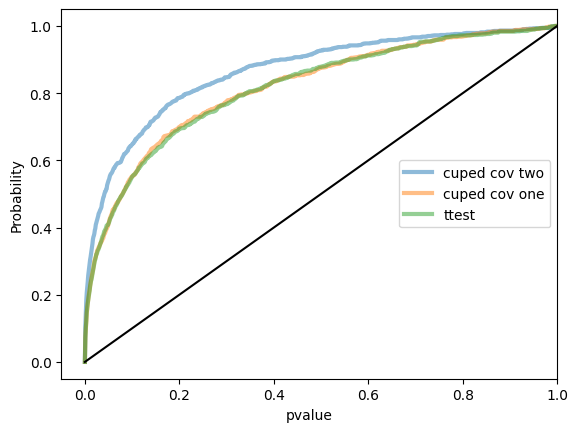

In [97]:
sample_size = 10000
corrs = np.random.uniform(0.01, 0.99, 1000)
pvalues_ttest = []
pvalues_cuped_cov_one = []
pvalues_cuped_cov_two = []

for corr in tqdm(corrs):
    control_users, pilot_users = np.random.choice(df_metrics.index, (2, sample_size,), False)
    df_control = df_metrics.loc[control_users]
    df_pilot = df_metrics.loc[pilot_users]
    df_pilot['metric'] += 20
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped_cov_one.append(check_cuped_test(df_control, df_pilot, 'cov_one'))
    pvalues_cuped_cov_two.append(check_cuped_test(df_control, df_pilot, 'cov_two'))


list_pvalues = [pvalues_ttest, pvalues_cuped_cov_one, pvalues_cuped_cov_two]
list_titles = ['ttest', 'cuped cov one', 'cuped cov two']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.ylabel('Probability') # proportion of p-values less than each threshold
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

- CUPED with covariate 'price' 1 week before the experiment 
is almost identical in power to t-test.
- CUPED with covariate 'price' in the 4th week before the experiment is noticeably better in power than t-test.

## CUPED + ML

In [98]:
def get_features(df, user_ids, date):
    """Generates features for prediction.

    The features are purchase values by week for 4 weeks..
    """
    features = [pd.DataFrame(index=user_ids)]
    for delta in range(0,22,7):   # (i.e., four 7-day windows: 7 days, 14 days, 21 days, and 28 days)
        date_begin = date - timedelta(delta + 7)
        date_end = date - timedelta(delta)
        features.append(
            df_sales
            [(df_sales['date'] >= date_begin) & (df_sales['date'] < date_end)]
            .groupby('user_id')[['price']].sum()
            .rename(columns={'price': f'delta_{delta}'})
        )
    df_features = pd.concat(features, axis=1).loc[user_ids].fillna(0)
    return df_features

# data for training
df_y_train = (
    df_sales
    [
      (df_sales['date'] >= begin_exp_date - timedelta(7))
      & (df_sales['date'] < end_exp_date - timedelta(7))
    ]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
)
df_x_train = get_features(df_sales, df_y_train.index, begin_exp_date - timedelta(7))
# data for prediction
df_x_test = get_features(df_sales, df_metrics.index, begin_exp_date)

In [99]:
# train the model
model = LGBMRegressor()
model.fit(df_x_train.values, df_y_train['metric'].values)

# predict the metric for the test data
predict = model.predict(df_x_test.values)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 24815, number of used features: 4
[LightGBM] [Info] Start training from score 1226.003224


/Users/Yanaorfin_1/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [100]:
df_metrics['predict'] = predict
df_metrics.corr()

,metric,cov_one,cov_two,predict
metric,1.000000,0.101480,0.503251,0.761580
cov_one,0.101480,1.000000,0.439640,0.155329
cov_two,0.503251,0.439640,1.000000,0.657252
predict,0.761580,0.155329,0.657252,1.000000


  0%|          | 0/1000 [00:00<?, ?it/s]

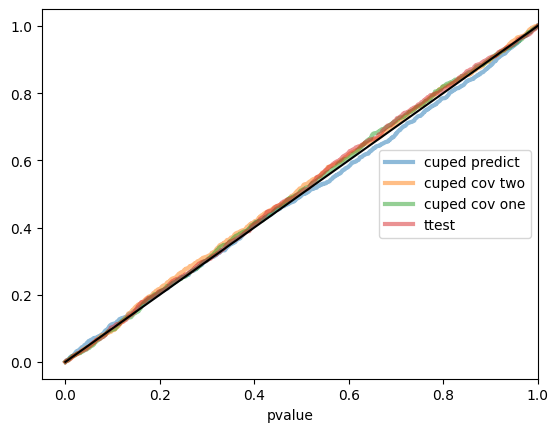

In [101]:
sample_size = 10000
pvalues_ttest = []
pvalues_cuped_cov_one = []
pvalues_cuped_cov_two = []
pvalues_cuped_predict = []

for corr in tqdm(corrs):
    control_users, pilot_users = np.random.choice(df_metrics.index, (2, sample_size,), False)
    df_control = df_metrics.loc[control_users]
    df_pilot = df_metrics.loc[pilot_users]
    df_pilot['metric'] += 0
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped_cov_one.append(check_cuped_test(df_control, df_pilot, 'cov_one'))
    pvalues_cuped_cov_two.append(check_cuped_test(df_control, df_pilot, 'cov_two'))
    pvalues_cuped_predict.append(check_cuped_test(df_control, df_pilot, 'predict'))


list_pvalues = [pvalues_ttest, pvalues_cuped_cov_one, pvalues_cuped_cov_two, pvalues_cuped_predict]
list_titles = ['ttest', 'cuped cov one', 'cuped cov two', 'cuped predict']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Experiment «Sending email (correct link)»

The experiment was conducted from 2022-04-25 through 2022-05-02. Metric - average revenue per client.
User revenue for the 4 weeks before the experiment is used as a covariate.

In [102]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-05-03/'

df_sales = read_database('2022-05-03T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_users=read_database('experiment_users.csv')

begin_date=datetime(2022,4,25)
end_date=datetime(2022,5,2)
begin_cov_date = begin_date - timedelta (days=28)

In [103]:
df_users.head()

,user_id,pilot
0,a9a6e8,0
1,23420a,0
2,cbc468,0
3,583c90,0
4,19ce47,0


In [104]:
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
    .reset_index()
)

df_cov=(
    df_sales[(df_sales['date']>=begin_cov_date) & (df_sales['date']< begin_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'covariate'})
    .reset_index()
)
df = pd.merge(df_users, df_metrics, on='user_id', how='left')
df = pd.merge(df, df_cov, on='user_id', how='left').fillna(0)

In [105]:

theta = calculate_theta(
    df.loc[df['pilot']==0,'metric'],
    df.loc[df['pilot']==1,'metric'],
    df.loc[df['pilot']==0,'covariate'],
    df.loc[df['pilot']==1,'covariate']
)
print(f'theta = {theta:0.4f}')

def check_cuped_test(df_control, df_pilot, covariate_column):
    metric_cuped_control = df.loc[df['pilot']==0,'metric'] - theta * df.loc[df['pilot']==0,'covariate']
    metric_cuped_pilot = df.loc[df['pilot']==1,'metric'] - theta * df.loc[df['pilot']==1,'covariate']
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    return pvalue

pvalue = check_cuped_test(df[df['pilot'] == 0], df[df['pilot'] == 1], 'covariate')
print(f'pvalue = {pvalue:0.4f}')

theta = 0.0884
pvalue = 0.0539


In [106]:
def calculate_cuped_theta(metric, cov):
    """Calculate Theta.

    :param metric (np.array): metric values during the pilot
    :param cov (np.array): covariate values
    """
    covariance = np.cov(cov, metric)[0, 1]
    variance = cov.var()
    theta = covariance / variance
    return theta


def calculate_cuped_metric(df_metric, df_cov):
    df = pd.merge(df_metric, df_cov, on='user_id')
    metric = df['metric'].values
    cov = df['cov'].values
    theta = calculate_cuped_theta(metric, cov)
    df['metric'] -= theta * (df['cov'] - df['cov'].mean())
    df.drop('cov', axis=1, inplace=True)
    return df

### Multiple testing

Now let's analyze the incident with the intersection of experiments in detail.

In our experiment (Font color) we tested the hypothesis about the influence of text color on the average revenue per client. But without waiting for it to end, someone started an experiment with different button background colors (Background color). For some people who were in both experiments at the same time, the text and the button background turned out to be the same color.

Experiment dates:

- Font color - from 2022-05-16 to 2022-05-23
- Background color - 2022-05-19 to 2022-05-26

In [107]:
begin_font = datetime(2022, 5, 16)
begin_back = datetime(2022, 5, 19)

end_font = datetime(2022, 5, 23)
end_back = datetime(2022, 5, 26)

In [108]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-05-27/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-05-27T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_users = read_database('experiment_users.csv')

In [109]:
df_users.head()

,user_id,Font color (control),Font color (pilot),Background color (control),Background color (pilot)
0,ec6536,1,0,0,0
1,82fdba,1,0,1,0
2,83d7c5,1,0,0,0
3,294d1c,1,0,1,0
4,faaa6f,1,0,0,1


Let's group by variants of getting into different groups, let's calculate the sizes of these groups.

In [110]:
df_users.groupby(df_users.columns.tolist()[1:])[['user_id']].count().reset_index()

,Font color (control),Font color (pilot),Background color (control),Background color (pilot),user_id
0,0,0,0,1,6294
1,0,0,1,0,6277
2,0,1,0,0,6553
3,0,1,0,1,6486
4,0,1,1,0,6658
5,1,0,0,0,6372
6,1,0,0,1,6643
7,1,0,1,0,6579


Let's plot total revenue by day by user group, depending on which experimental groups they fell into.

In [111]:
delta = timedelta(15)
df_sales_filtered = (
    df_sales
    [(df_sales['date'] >= begin_font - delta) & (df_sales['date'] < end_back)]
    [['user_id', 'price', 'date']]
    .copy()
)

df = pd.merge(
    df_users,
    df_sales_filtered,
    on='user_id',
    how='inner'
)

df['day'] = df['date'].dt.date
df['group'] = 'control'
df.loc[(df['Font color (pilot)'] == 1) & (df['Background color (pilot)'] == 0), 'group'] = 'Font pilot'
df.loc[(df['Font color (pilot)'] == 0) & (df['Background color (pilot)'] == 1), 'group'] = 'Background pilot'
df.loc[(df['Font color (pilot)'] == 1) & (df['Background color (pilot)'] == 1), 'group'] = 'both pilot'

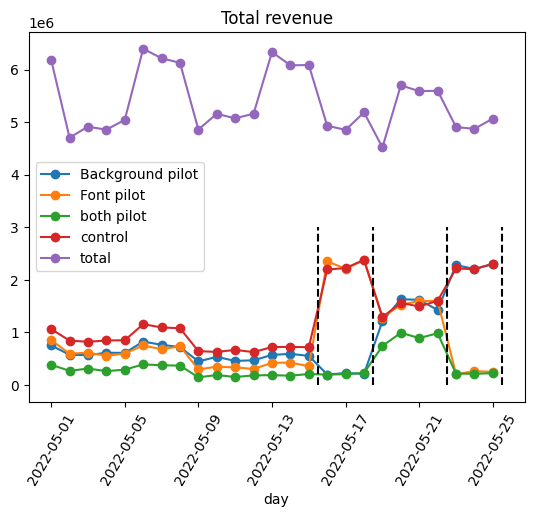

In [112]:
df_agg = df.groupby(['group', 'day'])[['price']].sum().reset_index().rename(columns={'price': 'revenue'})
df_pivot = df_agg.pivot(index='day', columns='group', values='revenue')

df_pivot = pd.merge(
    df_pivot,
    df_sales_filtered.groupby(df_sales_filtered['date'].dt.date)[['price']].sum().rename(columns={'price': 'total'}),
    left_index=True,
    right_index=True,
    how='left'
)

df_pivot.plot(rot=60, style='-o')

for date_ in [begin_font, end_font, begin_back, end_back]:
    plt.plot([date_ - timedelta(0.5), date_ - timedelta(0.5)], [0, 3000000], '--k')
    
plt.title('Total revenue')
plt.show()

During the intersection of the experiments, each of the 4 groups had approximately the same number of people. It can be seen that the revenue of the group that fell into both experiments at once is less.

### Experiment evaluation
Let's evaluate the significance of differences in average revenue per user using t-test.

In [113]:
df_users_exp = (
    df_users
    [(df_users['Font color (control)'] == 1) | (df_users['Font color (pilot)'] == 1)]
    [['user_id', 'Font color (control)', 'Font color (pilot)']]
    .copy()
)

df_sales_exp = (
    df_sales
    [(df_sales['date'] >= begin_font) & (df_sales['date'] < end_font)]
    .groupby('user_id')[['price']].sum()
    .reset_index()
)

df_exp = pd.merge(df_users_exp, df_sales_exp, on='user_id', how='left').fillna(0)

In [114]:
control = df_exp[df_exp['Font color (control)'] == 1]['price'].values
pilot = df_exp[df_exp['Font color (pilot)'] == 1]['price'].values

print(f'len(control) = {len(control)}, len(pilot) = {len(pilot)}')
print(f'np.mean(pilot) - np.mean(control) = {np.mean(pilot) - np.mean(control):0.2f}')
print(stats.ttest_ind(control, pilot))

len(control) = 19594, len(pilot) = 19697
np.mean(pilot) - np.mean(control) = -111.11
TtestResult(statistic=12.351179891447554, pvalue=5.575006488410081e-35, df=39289.0)


The average revenue per user decreased significantly.

Let's  remove the clients from the second experiment.

In [115]:
df_users_exp_two = (
    df_users
    [
        ((df_users['Font color (control)'] == 1) | (df_users['Font color (pilot)'] == 1))
        & (df_users['Background color (pilot)'] == 0)
    ]
    [['user_id', 'Font color (control)', 'Font color (pilot)']]
    .copy()
)

df_exp = pd.merge(df_users_exp_two, df_sales_exp, on='user_id', how='left').fillna(0)

In [116]:
control = df_exp[df_exp['Font color (control)'] == 1]['price'].values
pilot = df_exp[df_exp['Font color (pilot)'] == 1]['price'].values

print(f'len(control) = {len(control)}, len(pilot) = {len(pilot)}')
print(f'np.mean(pilot) - np.mean(control) = {np.mean(pilot) - np.mean(control):0.2f}')
print(stats.ttest_ind(control, pilot))

len(control) = 12951, len(pilot) = 13211
np.mean(pilot) - np.mean(control) = -4.22
TtestResult(statistic=0.38385425255319694, pvalue=0.7010895944356124, df=26160.0)


Differences are statistically insignificant

Number of parallel experiments
How many independent experiments can be run simultaneously if 10,000 observations are collected during the experiment?
Experiment parameters:

- testing the hypothesis of equality of means;
- significance level — 0.05;
- acceptable probability of type II error — 0.1;
- expected effect — 3% increase in values;
- method of adding the effect in synthetic A/B experiments — multiplication by a constant.

The distribution of measured values is a normal distribution with a mean of 100 and a standard deviation of 10.

In [167]:

total_size = 10000
mean_ = 100
std_ = 10
effect = 0.03
alpha = 0.05
beta = 0.1


def estimate_sample_size(effect, std, alpha, beta):
    """Evaluation of the required group size."""
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
    return sample_size


# We will assess the necessary size of the groups.
sample_size = estimate_sample_size(effect * 100, 10, alpha, beta)
print(f'sample_size = {sample_size}')
# We will calculate the number of experiments
count_exp = total_size / (sample_size * 2)
print(f'count_exp = {count_exp:0.1f}')


def estimate_ci_bernoulli(p, n, alpha=0.05):
    """Confidence interval for a Bernoulli random variable."""
    t = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    std_n = np.sqrt(p * (1 - p) / n)
    return p - t * std_n, p + t * std_n

# Check if errors are controlled at the specified levels for 21 experiments, and not for 22 experiments.

for count_exp in [21, 22]:
    errors_aa = []
    errors_ab = []
    sample_size = int(total_size / (int(count_exp) * 2))
    for _ in tqdm(range(10000)):
        a, b = np.random.normal(mean_, std_, (2, sample_size,))
        b_effect = b * (1 + effect)
        errors_aa.append(stats.ttest_ind(a, b).pvalue < alpha)
        errors_ab.append(stats.ttest_ind(a, b_effect).pvalue >= alpha)

    estimated_first_type_error = np.mean(errors_aa)
    estimated_second_type_error = np.mean(errors_ab)
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(errors_aa))
    ci_second = estimate_ci_bernoulli(estimated_second_type_error, len(errors_ab))
    print(f'count_exp = {count_exp}')
    print(f'sample_size = {sample_size}')
    print(f'estimating the probability of a Type I error = {estimated_first_type_error:0.4f}')
    print(f'  confidence interval = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')
    print(f'estimating the probability of a Type II error = {estimated_second_type_error:0.4f}')
    print(f'  confidence interval = [{ci_second[0]:0.4f}, {ci_second[1]:0.4f}]')

sample_size = 233
count_exp = 21.5


  0%|          | 0/10000 [00:00<?, ?it/s]

count_exp = 21
sample_size = 238
estimating the probability of a Type I error = 0.0523
  confidence interval = [0.0479, 0.0567]
estimating the probability of a Type II error = 0.1016
  confidence interval = [0.0957, 0.1075]


  0%|          | 0/10000 [00:00<?, ?it/s]

count_exp = 22
sample_size = 227
estimating the probability of a Type I error = 0.0520
  confidence interval = [0.0476, 0.0564]
estimating the probability of a Type II error = 0.1217
  confidence interval = [0.1153, 0.1281]


In experiment 21, everything is correct, but in experiment 22, the probability of a type II error is greater than 0.1.

# Independent experiments 
The task is similar to the previous one, except that now the decision is not made independently for each experiment.
For example, we have five texts for a marketing mailing list, and we want to check which one works better and whether any of them work at all.
The algorithm will be as follows:

1. We form non-overlapping control and experimental groups for each of the five options.
2. We conduct 5 experiments in parallel.
3. Using the Holm method, we determine in which experiments there were statistically significant differences.
4. If no significant differences are found, we say that there is no effect and reject all variants.
5. If significant differences are found, we select the variant with the lowest p-value from the variants with a significant effect and use it.

We will consider a Type I error to have been made if significant differences are found when in fact there were none in any of the variants.

We will consider a Type II error to have been made if:
- either no significant differences were found when in fact they existed;
- or the option selected for further use was in fact ineffective, while there were options with an effect.

Experiment parameters:

- we test the hypothesis of equality of means;
- significance level — 0.05;
- the acceptable probability of a Type II error is 0.1;
- the expected effect is a 3% increase in values;
- the method of adding the effect in synthetic A/B experiments is multiplication by a constant.
  

Note: When assessing the probability of a Type II error, consider the worst-case scenario, where the effect is present in only one of the experiments. The more experiments in which the effect is present, the lower the probability of a Type II error.

Let us assume that the distribution of measured values is a normal distribution with a mean of 100 and a standard deviation of 10.

Enter the maximum possible number of experiments that can be run with the above parameters as your answer.

In [168]:
def method_holm(pvalues, alpha=0.05):
    """Uses the Holm method to verify the significance of changes.
    
    pvalues - List[float] - list of pvalue.
    alpha - float, significance level.
    return - np.array, array of zeros and ones, 0 - no effect, 1 - effect exists.
    """
    m = len(pvalues)
    array_alpha = np.arange(m, 0, -1)
    array_alpha = alpha / array_alpha
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue < alpha_:
            res[pvalue_index] = 1
        else:
            break
    res = res.astype(int)
    return res

# Check if errors are controlled at the specified levels for 12 experiments, and not for 13 experiments.

for count_exp in [12, 13]:
    errors_aa = []
    errors_ab = []
    sample_size = int(total_size / (int(count_exp) * 2))
    for _ in tqdm(range(10000)):
        list_ab_values = [
            np.random.normal(mean_, std_, (2, sample_size))
            for _ in range(count_exp)
        ]
        # synthetic A/A test
        pvalues = [stats.ttest_ind(a, b).pvalue for a, b in list_ab_values]
        aa_with_effect = method_holm(pvalues, alpha)
        errors_aa.append(np.sum(aa_with_effect) > 0)

        # Synthetic A/B test.
        # It is enough to check the case when the effect is present in only one of the experiments,
        # since the presence of effects in a larger number of experiments will reduce Type II errors.
        # We will add the effect to the first experiment (it does not matter which one to add it to, since the data is random)
        list_ab_values[0][1] *= 1 + effect
        pvalues = [stats.ttest_ind(a, b).pvalue for a, b in list_ab_values]
        ab_with_effect = method_holm(pvalues, alpha)
        if np.sum(ab_with_effect) == 0:
            # If no effects are found, this is an error.
            errors_ab.append(True)
        else:
            # If effects are found where there are none, this is an error.
            errors_ab.append(np.min(pvalues) != pvalues[0])

    estimated_first_type_error = np.mean(errors_aa)
    estimated_second_type_error = np.mean(errors_ab)
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(errors_aa))
    ci_second = estimate_ci_bernoulli(estimated_second_type_error, len(errors_ab))
    print(f'count_exp = {count_exp}')
    print(f'sample_size = {sample_size}')
    print(f'assessment of the probability of a Type I error = {estimated_first_type_error:0.4f}')
    print(f'  confidence interval = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')
    print(f'assessment of the probability of a Type II error = {estimated_second_type_error:0.4f}')
    print(f'  confidence interval = [{ci_second[0]:0.4f}, {ci_second[1]:0.4f}]')

  0%|          | 0/10000 [00:00<?, ?it/s]

count_exp = 12
sample_size = 416
assessment of the probability of a Type I error = 0.0496
  confidence interval = [0.0453, 0.0539]
assessment of the probability of a Type II error = 0.0875
  confidence interval = [0.0820, 0.0930]


  0%|          | 0/10000 [00:00<?, ?it/s]

count_exp = 13
sample_size = 384
assessment of the probability of a Type I error = 0.0487
  confidence interval = [0.0445, 0.0529]
assessment of the probability of a Type II error = 0.1118
  confidence interval = [0.1056, 0.1180]


## Traffic Splitting

In [117]:
def add_experiment(experiment, buckets):
   # list [bucket_id, number of joint experiments] for buckets without conflicts
    available_buckets_meta = []
    for bucket_id, bucket in enumerate(buckets):
        if set(experiment['conflicts']) & set(bucket):
            continue
        available_buckets_meta.append((bucket_id, len(bucket)))
    if len(available_buckets_meta) < experiment['buckets_count']:
        # Not enough available buckets
        return False, buckets
    # First, we occupy buckets with a large number of experiments
    # to leave free buckets for non-collaborative experiments
    sorted_available_buckets_meta = sorted(available_buckets_meta, key=lambda x: -x[1])
    for bucket_id, _ in sorted_available_buckets_meta[:experiment['buckets_count']]:
        buckets[bucket_id].append(experiment['id'])
    return True, buckets

In [118]:
import hashlib


def get_hash_modulo(value: str, modulo: int, salt: str):
    """Calculate the remainder of the division: (hash(value + salt)) % modulo."""
    hash_value = int(hashlib.md5(str.encode(value + salt)).hexdigest(), 16)
    return hash_value % modulo

def process_user(user_id, buckets, experiments, bucket_salt):
    bucket_id = get_hash_modulo(user_id, len(buckets), bucket_salt)
    experiment_ids = buckets[bucket_id]
    bucket_experiments = [
        experiment for experiment in experiments
        if experiment['id'] in experiment_ids
    ]
    experiment_groups = []
    for experiment in bucket_experiments:
        second_hash = get_hash_modulo(user_id, 2, experiment['salt'])
        group = 'B' if second_hash == 1 else 'A'
        experiment_groups.append((experiment['id'], group))
    return bucket_id, experiment_groups

## Linearization

In [119]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')

In [120]:
sales = read_database('2022-04-01T12_df_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


 The test is conducted over a period of four weeks.  To do this, we will select a one-week interval from the historical period and perform all calculations for that time period. Note that today is April 1, so the data is taken from the week right before the experiment started.  

In [121]:
sales_hist = sales[
    (sales['date'] >= datetime(2022, 3, 1))
    & (sales['date'] < datetime(2022, 3, 29))
]
sales_hist.shape

(101951, 6)

 One user's purchases are dependent:

To verify the correctness of the experiment design, we must simulate this experiment multiple times on historical data. First, let's check whether the probability of a Type I error is controlled. For this, the objects in our sample will be **receipts**. That is, we divide all people into two groups, collect all receipts independently, and perform a t-test.

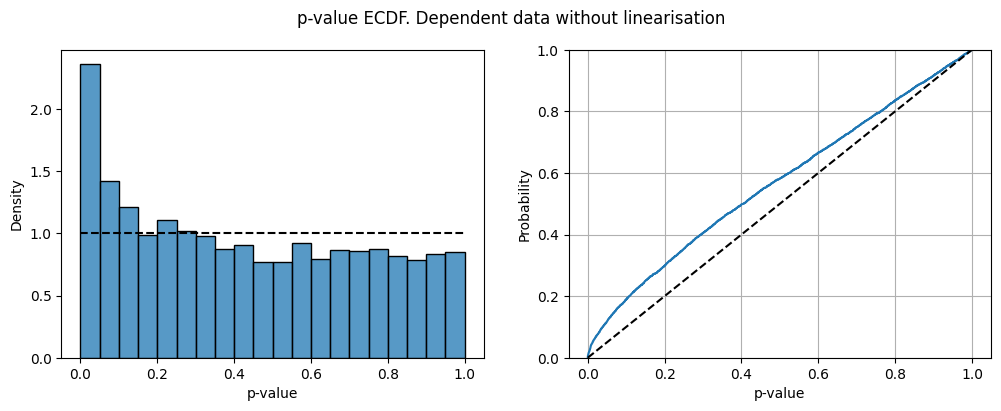

In [122]:
# Ttest without linearisation

p_values = []
users = sales_hist['user_id'].unique()
for _ in range (5000):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users)//2], users[len(users)//2:]
    sales_a = sales_hist[sales_hist['user_id'].isin(group_a)]['price']
    sales_b = sales_hist[sales_hist['user_id'].isin(group_b)]['price']
    _,p_value = ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data without linearisation')

The distribution obtained is skewed. This indicates that the test was incorrectly designed.

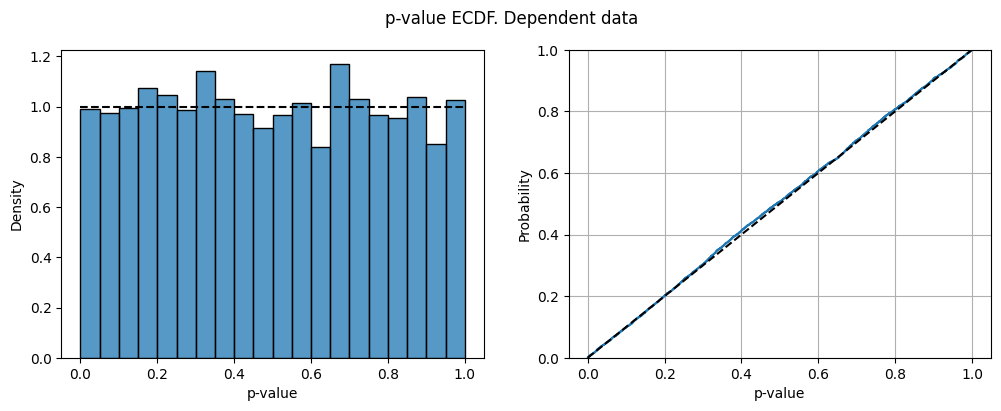

In [123]:
# Ttest with linearisation

p_values = []
users = sales_hist['user_id'].unique()
for _ in range(5000):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = sales_hist[sales_hist['user_id'].isin(group_a)][['user_id', 'price']]
    sales_b = sales_hist[sales_hist['user_id'].isin(group_b)][['user_id', 'price']]
    
    stat_a = sales_a.groupby('user_id')['price'].agg(['sum', 'count'])
    stat_b = sales_b.groupby('user_id')['price'].agg(['sum', 'count'])

    sum_a, count_a = stat_a.sum()
    sum_b, count_b = stat_b.sum()

    kappa = sum_a / count_a # average receipt for group A
    linearized_sales_a = stat_a['sum'] - kappa * stat_a['count']
    linearized_sales_b = stat_b['sum'] - kappa * stat_b['count']

    _, p_val = ttest_ind(linearized_sales_a, linearized_sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')


Evaluation of the “Refactoring backend” experiment using linearization, assuming that user data is dependent.
The metric is the average load time.

In [128]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-13/'


web_logs = read_database('2022-04-13T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])

In [145]:
web_logs

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8
...,...,...,...,...
2401704,f721f6,b,2022-04-13 11:59:54,78.3
2401705,1238da,b,2022-04-13 11:59:56,62.3
2401706,cc7e71,m,2022-04-13 11:59:58,67.4
2401707,1587e4,b,2022-04-13 11:59:59,74.3


In [150]:
users = read_database('experiment_users.csv')

In [132]:
begin_date = datetime(2022, 4, 5)
end_date = datetime(2022, 4, 12)

In [152]:
df_metrcis = (
    web_logs [ 
        (web_logs['date'] >= begin_date) & (web_logs['date'] < end_date)]
        .groupby('user_id')[['load_time']].agg(list)
        .reset_index())

In [153]:
users

,user_id,pilot
0,c36b2e,0
1,20336e,0
2,034652,0
3,e98e3b,0
4,3f1105,0
...,...,...
5451,7b4bba,1
5452,923ad6,1
5453,6e59e9,1
5454,bb8df6,1


In [154]:
df = pd.merge(users, df_metrcis, on = 'user_id', how = 'left')


In [155]:
df

,user_id,pilot,load_time
0,c36b2e,0,"[106.6, 49.6, 49.9, 75.7]"
1,20336e,0,"[61.6, 82.2, 67.4]"
2,034652,0,"[42.6, 68.6, 68.4, 63.5, 88.4, 68.9]"
3,e98e3b,0,"[62.3, 73.0, 80.5, 79.0, 73.9, 55.0, 64.0, 83...."
4,3f1105,0,"[84.0, 71.6, 64.2]"
...,...,...,...
5451,7b4bba,1,"[79.6, 78.9, 68.9, 81.1, 65.3, 89.2, 84.1, 70.1]"
5452,923ad6,1,"[72.8, 76.7, 80.9]"
5453,6e59e9,1,"[87.1, 58.8, 84.7, 79.1, 70.2, 74.7]"
5454,bb8df6,1,"[65.9, 78.5, 75.1, 68.6]"


In [156]:
def check_linearization(a, b):
    """Testing the hypothesis using linearization.
    
    a: List[List], list of sets of user session lengths for the control group
    b: List[List], list of sets of user session lengths for the pilot group
    
    return: p-value and point estimate.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

a = df[df['pilot'] == 0]['load_time'].values
b = df[df['pilot'] == 1]['load_time'].values

pvalue = check_linearization(a, b)[0]
print(f'pvalue = {pvalue:0.4f}')

pvalue = 0.0442


In [ ]:
def calculate_linearized_metrics(control_metrics, pilot_metrics):
    kappa = control_metrics['metric'].mean()
    dfs = []
    for df in [control_metrics, pilot_metrics]:
        df_agg = df.groupby('user_id')[['metric']].agg(['sum', 'count'])
        df_agg.columns = df_agg.columns.get_level_values(1)
        df_agg['metric'] = df_agg['sum'] - kappa * df_agg['count']
        df_agg.reset_index(inplace=True)
        dfs.append(df_agg[['user_id', 'metric']].copy())
    return dfs